In [1]:
import pandas as pd
import numpy as np
import pathlib
import math
import tqdm
from  open_ephys import analysis as oea
from matplotlib import pyplot as plt
from BlockSync_current import *
import scipy.io
import h5py
import re

In [2]:
# initialize some things
#block definition
experiments_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = "PV_62"
date = "2023_06_21"
block_n = "072"

block = BlockSync(animal_call=animal,
                  experiment_date=date,block_num=block_n,
                  path_to_animal_folder=str(experiments_path),regev=True)

# oe session definition (maybe redundent? do I really use their classes?)
session = oea.Session(str(block.oe_path.parent))
recording = session.recordnodes[0].recordings[0] # this assumes a single recording per block (as my data is organized for now)
oe_metadata_file_path = [i for i in pathlib.Path(recording.directory).iterdir() if 'OE_metaData' in str(i)][0]


instantiated block number 072 at Path: Z:\Nimrod\experiments\PV_62\2023_06_21\block_072, new OE version
Found the sample rate for block 072 in the xml file, it is 20000 Hz


In [3]:
class OERecording:
    """
    This is a class designed to get the metadata of an open-ephys format recording that was first analyzed by Mark's matlab code -
    I should probably make an independent function sometime in the future but for now this class reads the produced metadata file to allow efficient access to the recording
    """
    # define a helper function to get a group out of an hdf5 file (without resolving internal references!)

    def group_to_dict(self, group):
        result = {}
        for key, item in group.items():
            if isinstance(item, h5py.Group):
                result[key] = self.group_to_dict(item)
            else:

                result[key] = item[()]  # Convert dataset to NumPy array and assign its value
        return result

    def __init__(self, oe_metadata_file_path):
        # create the metadata_dict object:
        # open the mat file:
        mat_file = h5py.File(oe_metadata_file_path, 'r')

        #implement on the metaData group:
        meta_dict = self.group_to_dict(mat_file['metaData'])

        # resolve internal references of blkCont object:
        # get to the blkCont mat and reform it from reference instances
        blkCont_dict = {
            'Repeat':[],
            'Types':[],
            'Str':[]
        }
        blkCont_group = mat_file['metaData/blkCont']
        for i in blkCont_group['Repeat']:
            res = np.array(mat_file[i[0]][0])
            blkCont_dict['Repeat'].append(res[0])

        for i in blkCont_group['Types']:
            res = np.array((mat_file[i[0]]))
            str_array = np.vectorize(chr)(res).flatten()
            str_value = ''.join(str_array.flatten())
            blkCont_dict['Types'].append(str_value)

        for i in blkCont_group['Str']:
            res = np.array(mat_file[i[0]])
            str_array = np.vectorize(chr)(res).flatten()
            str_value = ''.join(str_array.flatten())
            blkCont_dict['Str'].append(str_value)

        #close the file
        mat_file.close()

        # switch out the dictionary blkCont attribute
        meta_dict['blkCont'] = blkCont_dict
        # parse a dictionary into attributes of the class
        for key, value in meta_dict.items():
            setattr(self, key, value)
        # add some stuff from Mark's class that's not in the metadata
        self.headerSizeByte = 1024
        self.fileExtension = 'continuous'
        self.eventFileExtension = 'events'
        self.signalBits = 16 # the quantization of the sampling card
        self.dataSamplesPerRecord = 1024
        self.maxTTLBit = 9
        self.oe_file_path = oe_metadata_file_path.parent
        def extract_number_from_file(filename, suffix):
            match = re.search(r'(\d+)\.' + suffix + '$', filename)
            if match:
                return int(match.group(1))
            else:
                return None
        self.channel_files = sorted([i.name for i in oe_metadata_file_path.parent.iterdir() if ('.continuous' in str(i)) & ('AUX' not in str(i)) & ('ADC' not in str(i)) ],
                                    key=lambda x: extract_number_from_file(x, suffix='continuous'))
        self.analog_files = sorted([i.name for i in oe_metadata_file_path.parent.iterdir() if ('AUX' in str(i)) or ('ADC' in str(i))],
                                   key=lambda x: extract_number_from_file(x, suffix='continuous'))

In [13]:
oe = OERecording(oe_metadata_file_path=oe_metadata_file_path)

In [14]:
oe.MicrovoltsPerAD

array([[0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195],
       [0.195]])

In [16]:
def get_data_current(oe, channels, startTime_ms, window_ms, convert_to_mV=True):
    """
    This is a translated matlab function that efficiently retrieves data from Open-Ephys format neural recordings
    :param oe: an OERecording class obj. with a metadata file created by the matlab class with the same name
    :param channels: a vector of channel numbers to sample from [1XN channels]
    :param startTime_ms: a vector of window start times [1XN] in ms
    :param window_ms: a single value, the length of the sampling window from each startTime [ms_value]
    :param convert_to_mV: when True, turns the output into the mV representation of the sampled data
    :return: V_uV - an array with the shape [nChannels, nWindows, nSamples] and either the int16 / mV values
    """
    windowSamples = int(np.round(window_ms/oe.sample_ms)) # round the time in ms to the nearest whole sample count
    nWindows = len(startTime_ms) # get the number of start times provided
    startTime_ms = np.round(startTime_ms / oe.sample_ms) * oe.sample_ms # round the start times to the nearest whole sample multiple
    window_ms = windowSamples*oe.sample_ms # get the ms based length of the rounded window

    # deal with the channel numbers:
    if len(channels) == 0 or channels is None: #if no channels were provided
        channels = oe.channelNumbers

    if not all([c in oe.channelNumbers for c in channels]): #if requested channels do not exist in the file
        raise ValueError('one or more of the entered channels does not exist in the recording!')
    nCh = len(channels)

    #initialize some variables for the data extraction:
    V_uV = np.zeros(shape=(int(windowSamples),nWindows,nCh), dtype=oe.blkCont['Types'][3], order='F') #initialize the waveform matrix

    p_rec_idx = []  # List to store the record indices for waveform extraction
    read_start_indices = [] # List to store the indices where reading from the file should start (one per reading window)
    records_per_trial_list = []
    for i in range(nWindows):
        # find the relevant record blocks in the block list:
        p_single_trial_time_stamps = np.where((oe.allTimeStamps[0] >= (startTime_ms[0][i] - oe.recordLength)) & (oe.allTimeStamps[0] < (startTime_ms[0][i] + window_ms)))[1]
        read_start_indices.append(p_single_trial_time_stamps[0]) # this collects the indices to start reading from
        single_trial_time_stamps = np.round(oe.allTimeStamps[0][p_single_trial_time_stamps] / oe.sample_ms) * oe.sample_ms  # Calculate time stamps in milliseconds based on sampling freq & record block length
        records_per_trial = len(single_trial_time_stamps[0])  # Get the number of records per trial
        records_per_trial_list.append(records_per_trial)
        # This is problematic, should give me the right time index selections consistently
        time_idx = np.tile((np.arange(oe.dataSamplesPerRecord) * oe.sample_ms).reshape(-1, 1), (1, records_per_trial)) + single_trial_time_stamps.reshape(1, -1)
        if i==0:
            p_rec_idx.append((time_idx >= startTime_ms[0][i]) & (time_idx < (startTime_ms[0][i] + window_ms)))  # Find time indices within the requested time window (chunks are 1024 in size so they are usually cut for most time windows, this is saved as a boolean matrix)
        else:
            p_rec_idx.append((time_idx >= startTime_ms[0][i]) & (time_idx < (startTime_ms[0][i] + window_ms)))

        if np.sum(p_rec_idx[i]) == windowSamples + 1:  # Due to rounding issues, there may be an error when there is one sample too much - in this case the last sample is removed
            print(f'sample removed {i}')
            p_rec_idx[i][0, np.where(p_rec_idx[i][0, :] == 1)[0][0]] = False

        time_idx = time_idx.T
        #p_out_idx.append(np.round((time_idx[p_rec_idx[i].T] - startTime_ms[0][i]) / oe.sample_ms) + windowSamples * i)  # Calculate the output indices for waveform extraction

    # if p_out_idx[0][0][0] == -1:  # Special case handling where the first index is 0 (due to rounding) -> might be redundent with python
    #     p_out_idx[0] += 1

    p_rec_idx = np.hstack(p_rec_idx)  # Concatenate record indices into a single array
    # p_out_idx = np.hstack(p_out_idx)  # Concatenate output indices into a single array


    # now for the data extraction itself:
    for i in range(nCh): # iterate over channels
        data = np.zeros(p_rec_idx.shape, dtype=np.dtype('>i2'))  # Initialize the data array for a specific channel
        curr_rec = 0 # for this channel, initialize the record counter
        c_file = oe.oe_file_path / oe.channel_files[channels[i]-1] # get the path to the relevant channel file
        with open(c_file,'rb') as fid: #open the file such that it will close when left alone
            for j in range(nWindows): # Iterate over sampling windows
                fid.seek(int(oe.headerSizeByte + (read_start_indices[j] * oe.bytesPerRecCont) + np.sum(oe.blkBytesCont[0:3])), 0) # use seek to go to the appropriate position in the file
                skip_size = int(oe.bytesPerRecCont[0][0] - oe.blkBytesCont[3][0]) // 2 # calculate the skip size, cut in half because each int16 is 2 bytes and the matlab function takes bytes as skip
                # (which fromfile does not, uniform datatype)
                read_size = oe.dataSamplesPerRecord
                total_bytes = (read_size + skip_size) * records_per_trial_list[j] # calculate total element count to read
                data_plus_breaks = np.fromfile(fid, dtype=np.dtype('>i2'), count=total_bytes, sep='') # read data from file in a single vector, including skip_data
                data_plus_breaks = data_plus_breaks.reshape(int(records_per_trial_list[j]), read_size + skip_size) # reshape into an array with a column-per-record shape
                clean_data = data_plus_breaks[:, :read_size] # slice the array to get rid of the skip_data at the end of each column (record)
                data[:, curr_rec : curr_rec + records_per_trial_list[j]] = clean_data.T # transpose and store the current_rec data
                curr_rec = curr_rec + records_per_trial_list[j] # move forward to the next reading window
        # this loop exit closes the current channel file
        data_vec = data.T[p_rec_idx.T] # vectorize the data from the channel and perform a boolean snipping of non-window samples
        V_uV[:,:,i] = data_vec.reshape(int(windowSamples), nWindows, order='F') # put the data in the final V_uV waveform matrix

    V_uV = np.transpose(V_uV,[2,1,0])

    if convert_to_mV:
        V_uV = V_uV* oe.MicrovoltsPerAD[0]
        return V_uV
    else:
        return V_uV

In [72]:
%%time

data_array = get_data_current(oe,[1],[10000, 20000, 30000],[500],True)
data_vec = np.concatenate([data_array[0,0,:],data_array[0,1,:],data_array[0,2,:]])
mat_vec = scipy.io.loadmat(pathlib.Path('Z:/Nimrod/HelperFiles/c_vec.mat'))
c_vec = mat_vec['comp_vec'][:,0]
np.array_equal(c_vec,data_vec)

Wall time: 15.6 ms


True

In [71]:
np.array_equal(c_vec[:,0],data_vec)
#np.shape(c_vec[:,0])

True

In [385]:
# check stuff here:


#### THIS IS THE NEWEST VERSION ####
# rounding the inputs to clean multiples of the sample timestep:
channels=[1]
startTime_ms = [10000, 20000]
window_ms = 500

windowSamples = int(np.round(window_ms/oe.sample_ms)) # round the time in ms to the nearest whole sample count
nWindows = len(startTime_ms) # get the number of start times provided
startTime_ms = np.round(startTime_ms / oe.sample_ms) * oe.sample_ms # round the start times to the nearest whole sample multiple
window_ms = windowSamples*oe.sample_ms # get the ms based length of the rounded window

# deal with the channel numbers:
if len(channels) == 0 or channels is None: #if no channels were provided
    channels = oe.channelNumbers

if not all([c in oe.channelNumbers for c in channels]): #if requested channels do not exist in the file
    raise ValueError('one or more of the entered channels does not exist in the recording!')
nCh = len(channels)

#initialize some variables for the data extraction:
V_uV = np.zeros(shape=(int(windowSamples),nWindows,nCh), dtype=oe.blkCont['Types'][3], order='F') #initialize the waveform matrix

p_out_idx = []  # List to store the output indices for waveform extraction
p_rec_idx = []  # List to store the record indices for waveform extraction
read_start_indices = [] # List to store the indices where reading from the file should start (one per reading window)
records_per_trial_list = []
for i in range(nWindows):
    # find the relevant blocks in the block list:
    p_single_trial_time_stamps = np.where((oe.allTimeStamps[0] >= (startTime_ms[0][i] - oe.recordLength)) & (oe.allTimeStamps[0] < (startTime_ms[0][i] + window_ms)))[1]
    read_start_indices.append(p_single_trial_time_stamps[0])
    # TODO: deal with the edge case where the start index is at 0
    #
    # if p_single_trial_time_stamps[0] == 0:
    #     read_start_indices.append(p_single_trial_time_stamps[0])
    # else:
    #     read_start_indices.append(p_single_trial_time_stamps[0])

    single_trial_time_stamps = np.round(oe.allTimeStamps[0][p_single_trial_time_stamps] / oe.sample_ms) * oe.sample_ms  # Calculate time stamps in milliseconds
    records_per_trial = len(single_trial_time_stamps[0])  # Get the number of records per trial
    records_per_trial_list.append(records_per_trial)
    # This is problematic, should give me the right time index selections consistently
    time_idx = np.tile((np.arange(oe.dataSamplesPerRecord) * oe.sample_ms).reshape(-1, 1), (1, records_per_trial)) + single_trial_time_stamps.reshape(1, -1)
    if i==0:
        p_rec_idx.append((time_idx >= startTime_ms[0][i]) & (time_idx < (startTime_ms[0][i] + window_ms)))  # Find time indices within the requested time window (chunks are 1024 in size so they are usually cut for most time windows, this is saved as a boolean matrix)
    else:
        p_rec_idx.append((time_idx >= startTime_ms[0][i]) & (time_idx < (startTime_ms[0][i] + window_ms)))

    if np.sum(p_rec_idx[i]) == windowSamples + 1:  # Due to rounding issues, there may be an error when there is one sample too much - in this case the last sample is removed
        print(f'sample removed {i}')
        p_rec_idx[i][0, np.where(p_rec_idx[i][0, :] == 1)[0][0]] = False

    time_idx = time_idx.T
    #p_out_idx.append(np.round((time_idx[p_rec_idx[i].T] - startTime_ms[0][i]) / oe.sample_ms) + windowSamples * i)  # Calculate the output indices for waveform extraction

# if p_out_idx[0][0][0] == -1:  # Special case handling where the first index is 0 (due to rounding) -> might be redundent with python
#     p_out_idx[0] += 1

p_rec_idx = np.hstack(p_rec_idx)  # Concatenate record indices into a single array
# p_out_idx = np.hstack(p_out_idx)  # Concatenate output indices into a single array


# now for the data extraction itself:
# first, iterate over channels:
for i in range(nCh):
    data = np.zeros(p_rec_idx.shape, dtype=np.dtype('>i2'))  # Initialize the data array for a specific channel
    curr_rec = 0
    c_file = oe.oe_file_path / oe.channel_files[channels[i]-1] # get the channel file to read from
    with open(c_file,'rb') as fid: #open the file such that it will close when left alone
        for j in range(nWindows):
            fid.seek(int(oe.headerSizeByte + (read_start_indices[j] * oe.bytesPerRecCont) + np.sum(oe.blkBytesCont[0:3])), 0) # use seek to go to the appropriate position in the file
            skip_size = int(oe.bytesPerRecCont[0][0] - oe.blkBytesCont[3][0]) // 2 # calculate the skip size, cut in half because each int16 is 2 bytes and the matlab function takes bytes as skip
            # (which fromfile does not, uniform datatype)
            read_size = oe.dataSamplesPerRecord
            total_bytes = (read_size + skip_size) * records_per_trial_list[j] # calculate total element count to read
            data_plus_breaks = np.fromfile(fid, dtype=np.dtype('>i2'), count=total_bytes, sep='') # read data from file in a single vector, including skip_data
            data_plus_breaks = data_plus_breaks.reshape(int(records_per_trial_list[j]), read_size + skip_size) # reshape into an array with a column per-record
            clean_data = data_plus_breaks[:, :read_size] # slice the array to get rid of the skip_data
            data[:, curr_rec : curr_rec + records_per_trial_list[j]] = clean_data.T
            curr_rec = curr_rec + records_per_trial_list[j]
    data_vec = data.T[p_rec_idx.T] # vectorize the data and perform a boolean snipping of non-window samples
    V_uV[:,:,i] = data_vec.reshape(int(windowSamples), nWindows, order='F') # put the data in the final V_uV waveform matrix

V_uV = np.transpose(V_uV,[2,1,0])

In [4]:
np.tile((np.arange(oe.dataSamplesPerRecord) * oe.sample_ms).reshape(-1, 1), (1, records_per_trial))

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [376]:
# vector comparison
py_vec = data_vec * oe.MicrovoltsPerAD[0]
mat_vec = scipy.io.loadmat(pathlib.Path('Z:/Nimrod/HelperFiles/c_vec.mat'))
c_vec = mat_vec['c_vec']
c_vec = c_vec[:,0]
#c_vec[0] = 111
mat_vec = np.vstack((py_vec,c_vec))

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e-02, 5.000e-02, 5.000e-02, ..., 5.000e-02, 5.000e-02,
        5.000e-02],
       [1.000e-01, 1.000e-01, 1.000e-01, ..., 1.000e-01, 1.000e-01,
        1.000e-01],
       ...,
       [5.105e+01, 5.105e+01, 5.105e+01, ..., 5.105e+01, 5.105e+01,
        5.105e+01],
       [5.110e+01, 5.110e+01, 5.110e+01, ..., 5.110e+01, 5.110e+01,
        5.110e+01],
       [5.115e+01, 5.115e+01, 5.115e+01, ..., 5.115e+01, 5.115e+01,
        5.115e+01]])

In [4]:
mat_vec.T

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [376]:
#p_rec_idx.append((time_idx >= startTime_ms[0][i]) & (time_idx < (startTime_ms[0][i] + window_ms)))
mat_vec.T

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e-02, 5.000e-02, 5.000e-02, ..., 5.000e-02, 5.000e-02,
        5.000e-02],
       [1.000e-01, 1.000e-01, 1.000e-01, ..., 1.000e-01, 1.000e-01,
        1.000e-01],
       ...,
       [5.105e+01, 5.105e+01, 5.105e+01, ..., 5.105e+01, 5.105e+01,
        5.105e+01],
       [5.110e+01, 5.110e+01, 5.110e+01, ..., 5.110e+01, 5.110e+01,
        5.110e+01],
       [5.115e+01, 5.115e+01, 5.115e+01, ..., 5.115e+01, 5.115e+01,
        5.115e+01]])

In [4]:
time_idx.T

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [376]:
read_start_indices

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e-02, 5.000e-02, 5.000e-02, ..., 5.000e-02, 5.000e-02,
        5.000e-02],
       [1.000e-01, 1.000e-01, 1.000e-01, ..., 1.000e-01, 1.000e-01,
        1.000e-01],
       ...,
       [5.105e+01, 5.105e+01, 5.105e+01, ..., 5.105e+01, 5.105e+01,
        5.105e+01],
       [5.110e+01, 5.110e+01, 5.110e+01, ..., 5.110e+01, 5.110e+01,
        5.110e+01],
       [5.115e+01, 5.115e+01, 5.115e+01, ..., 5.115e+01, 5.115e+01,
        5.115e+01]])

In [4]:
a = V_uV * oe.MicrovoltsPerAD[0]
a[0,0,:]

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [376]:
p_rec_idx

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e-02, 5.000e-02, 5.000e-02, ..., 5.000e-02, 5.000e-02,
        5.000e-02],
       [1.000e-01, 1.000e-01, 1.000e-01, ..., 1.000e-01, 1.000e-01,
        1.000e-01],
       ...,
       [5.105e+01, 5.105e+01, 5.105e+01, ..., 5.105e+01, 5.105e+01,
        5.105e+01],
       [5.110e+01, 5.110e+01, 5.110e+01, ..., 5.110e+01, 5.110e+01,
        5.110e+01],
       [5.115e+01, 5.115e+01, 5.115e+01, ..., 5.115e+01, 5.115e+01,
        5.115e+01]])

In [4]:
time_idx

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [376]:
%%time
d = get_data_current(oe, [1,5], [0, 10000, 20000], 500)


array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e-02, 5.000e-02, 5.000e-02, ..., 5.000e-02, 5.000e-02,
        5.000e-02],
       [1.000e-01, 1.000e-01, 1.000e-01, ..., 1.000e-01, 1.000e-01,
        1.000e-01],
       ...,
       [5.105e+01, 5.105e+01, 5.105e+01, ..., 5.105e+01, 5.105e+01,
        5.105e+01],
       [5.110e+01, 5.110e+01, 5.110e+01, ..., 5.110e+01, 5.110e+01,
        5.110e+01],
       [5.115e+01, 5.115e+01, 5.115e+01, ..., 5.115e+01, 5.115e+01,
        5.115e+01]])

In [4]:
data_tester = V_uV * oe.MicrovoltsPerAD[0]
prec_tester = p_rec_idx
p = pathlib.Path(r'Z:/Nimrod/HelperFiles/dataTester.mat')
scipy.io.savemat(p,{'data':data_tester, 'prec':prec_tester})

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [376]:
V_uV

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e-02, 5.000e-02, 5.000e-02, ..., 5.000e-02, 5.000e-02,
        5.000e-02],
       [1.000e-01, 1.000e-01, 1.000e-01, ..., 1.000e-01, 1.000e-01,
        1.000e-01],
       ...,
       [5.105e+01, 5.105e+01, 5.105e+01, ..., 5.105e+01, 5.105e+01,
        5.105e+01],
       [5.110e+01, 5.110e+01, 5.110e+01, ..., 5.110e+01, 5.110e+01,
        5.110e+01],
       [5.115e+01, 5.115e+01, 5.115e+01, ..., 5.115e+01, 5.115e+01,
        5.115e+01]])

In [376]:
p_rec_idx.T

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e-02, 5.000e-02, 5.000e-02, ..., 5.000e-02, 5.000e-02,
        5.000e-02],
       [1.000e-01, 1.000e-01, 1.000e-01, ..., 1.000e-01, 1.000e-01,
        1.000e-01],
       ...,
       [5.105e+01, 5.105e+01, 5.105e+01, ..., 5.105e+01, 5.105e+01,
        5.105e+01],
       [5.110e+01, 5.110e+01, 5.110e+01, ..., 5.110e+01, 5.110e+01,
        5.110e+01],
       [5.115e+01, 5.115e+01, 5.115e+01, ..., 5.115e+01, 5.115e+01,
        5.115e+01]])

In [4]:
#data[np.where(p_rec_idx)]
data_vec = data.flatten('F')[p_rec_idx.flatten('F')]
data_vec.reshape(np.shape(V_uV)[:2],order='F')

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [48]:
data


array([[  42,  180,  -47],
       [  71,  172,  -27],
       [ 118,  132,    3],
       ...,
       [-205,   76,  154],
       [-234,  224,  154],
       [-193,  266,  258]], dtype=int16)

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [48]:
print(p_rec_idx.shape)
print(V_uV.shape)
print(data.shape)
print(records_per_trial_list)
a = V_uV.flatten()
a = np.zeros(60000)
int(oe.bytesPerRecCont[0][0] - oe.blkBytesCont[3][0])
oe.headerSizeByte + (read_start_indices[1] * oe.bytesPerRecCont) + np.sum(oe.blkBytesCont[0:3])

array([[  42,  180,  -47],
       [  71,  172,  -27],
       [ 118,  132,    3],
       ...,
       [-205,   76,  154],
       [-234,  224,  154],
       [-193,  266,  258]], dtype=int16)

In [ ]:
# get to the blkCont mat and reform it from reference instances
blkCont_dict = {
    'Repeat':[],
    'Types':[],
    'Str':[]
}
mat_file = h5py.File(oe_metadata_file_path)
blkCont_group = mat_file['metaData/blkCont']
for i in blkCont_group['Repeat']:
    res = np.array(mat_file[i[0]][0])
    blkCont_dict['Repeat'].append(res[0])

for i in blkCont_group['Types']:
    res = np.array((mat_file[i[0]]))
    str_array = np.vectorize(chr)(res).flatten()
    str_value = ''.join(str_array.flatten())
    blkCont_dict['Types'].append(str_value)

for i in blkCont_group['Str']:
    res = np.array(mat_file[i[0]])
    str_array = np.vectorize(chr)(res).flatten()
    str_value = ''.join(str_array.flatten())
    blkCont_dict['Str'].append(str_value)

mat_file.close()
print(blkCont_dict)

In [0]:
pd.DataFrame(data=blkCont_dict)

# necessary attributes for get_data:
channelNumbers - V
blkCont - V
allTimeStamps - V
recordLength - V
sample_ms - V
dataSamplesPerRecord - V
n2s - V
headerSizeByte - V
bytesPerRecCont - V
blkBytesCont - V
MicrovoltsPerAD - V
samplingFrequency - V

In [10]:
def parse_hdf5_file(filename):
    def parse_group(group):
        result = {}
        for key, value in group.items():
            if isinstance(value, h5py.Dataset):
                result[key] = value[()]  # Convert dataset to numpy array
            elif isinstance(value, h5py.Group):
                result[key] = parse_group(value)  # Recursively parse nested group
            else:
                result[key] = value  # For other types, include them as-is
        return result

    def resolve_reference(file, reference):
        obj = file[reference]
        if isinstance(obj, h5py.Group):
            return parse_group(obj)
        elif isinstance(obj, h5py.Dataset):
            return obj[()]
        else:
            return obj

    def resolve_references(file, dataset):
        if h5py.check_dtype(ref=dataset.dtype):
            return np.array([resolve_reference(file, ref) for ref in dataset])
        else:
            return dataset

    with h5py.File(filename, 'r') as file:
        result = parse_group(file)
        for key, value in result.items():
            if isinstance(value, np.ndarray):
                result[key] = resolve_references(file, value)
        return result

In [8]:
#[i.name for i in oe_metadata_file_path.parent.iterdir() if ('AUX' in str(i)) or ('ADC' in str(i)) ]
sorted([i.name for i in oe_metadata_file_path.parent.iterdir() if ('AUX' in str(i)) or ('ADC' in str(i))])

['100_RhythmData_ADC1.continuous',
 '100_RhythmData_ADC2.continuous',
 '100_RhythmData_ADC3.continuous',
 '100_RhythmData_ADC4.continuous',
 '100_RhythmData_ADC5.continuous',
 '100_RhythmData_ADC6.continuous',
 '100_RhythmData_ADC7.continuous',
 '100_RhythmData_ADC8.continuous',
 '100_RhythmData_C1-AUX1.continuous',
 '100_RhythmData_C1-AUX2.continuous',
 '100_RhythmData_C1-AUX3.continuous']

In [11]:
result = parse_hdf5_file(oe_metadata_file_path)


In [12]:

result['metaData']

{'ADBitVolts': array([0, 0], dtype=uint64),
 'MicrovoltsPerAD': array([[0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195],
        [0.195]]),
 'MicrovoltsPerADAnalog': array([[ 37.4  ],
        [ 37.4  ],
        [ 37.4  ],
        [152.588],
        [152.588],
        [152.588],
        [152.588],
        [152.588],
        [152.588],
        [152.588],
        [152.588]]),
 'ZeroADValue': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],


In [210]:
# get data from a mat file into a dictionary:
# define the funciton that reads an HDF5 file group and converts it into a dictionary in python:

def group_to_dict(group):
    result = {}
    for key, item in group.items():
        if isinstance(item, h5py.Group):
            result[key] = group_to_dict(item)
        else:

            result[key] = item[()]  # Convert dataset to NumPy array and assign its value
    return result

# open the mat file:
mat_file = h5py.File(oe_metadata_file_path, 'r')

#implement on the metaData group:
meta_dict = group_to_dict(mat_file['metaData'])

#close the file
mat_file.close()

# I now have the dictionary - I should create the recording class and assign the different keys to internal properties of the recording
oeRec = OERecording(metadata_dict=meta_dict)


In [207]:
def find_references_recursive(obj):
    if isinstance(obj, h5py.Dataset):
        if h5py.check_dtype(ref=obj.dtype):
            references = obj[...]
            print(f"Found references: {references}")
    elif isinstance(obj, h5py.Group):
        for key in obj.keys():
            find_references_recursive(obj[key])
    elif isinstance(obj, (list, tuple)):
        for item in obj:
            find_references_recursive(item)

def find_hdf5_references(filename):
    with h5py.File(filename, 'r') as file:
        find_references_recursive(file)

# Usage example:
filename = oe_metadata_file_path
find_hdf5_references(filename)


Found references: [[<HDF5 object reference> <HDF5 object reference>]]
Found references: [[<HDF5 object reference> <HDF5 object reference>]]
Found references: [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
Found references: [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
Found references: [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
Found references: [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
Found references: [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]
Found ref

In [185]:
# Over here I converted a reference object into data for the first time

mat_file = h5py.File(oe_metadata_file_path, 'r')
ref = mat_file['metaData/blkCont/Repeat'][3][0]
res = np.array(mat_file[ref])

mat_file.close()

In [209]:
def construct_dict_with_references(filename):
    def construct_dict_recursive(obj):
        if isinstance(obj, h5py.Dataset):
            if h5py.check_dtype(ref=obj.dtype):
                references = obj[...]
                return resolve_references(references)
            else:
                return obj[()]  # Convert dataset to numpy array
        elif isinstance(obj, h5py.Group):
            result = {}
            for key in obj.keys():
                result[key.decode()] = construct_dict_recursive(obj[key])
            return result
        elif isinstance(obj, (list, tuple)):
            return [construct_dict_recursive(item) for item in obj]
        else:
            return obj

    def resolve_references(references):
        if isinstance(references, list):
            return [resolve_reference(ref) for ref in references]
        elif isinstance(references, np.ndarray):
            return np.array([resolve_reference(ref) for ref in references])
        else:
            return resolve_reference(references)

    def resolve_reference(reference):
        obj = file[reference.decode()]
        if isinstance(obj, h5py.Group):
            return construct_dict_recursive(obj)
        elif isinstance(obj, h5py.Dataset):
            return obj[()]
        else:
            return obj

    with h5py.File(filename, 'r') as file:
        return construct_dict_recursive(file)

# Usage example:
filename = oe_metadata_file_path
result = construct_dict_with_references(filename)
print(result)

AttributeError: 'str' object has no attribute 'decode'

In [4]:
### 1. get the metadata into a dictionary with

# Open the .mat file
mat_file = h5py.File(oe_metadata_file_path, 'r')

# Explore the file structure
print("File structure:")
print(mat_file)

# List all the keys (group and dataset names) in the root group
print("Keys in the root group:")
print(list(mat_file.keys()))

# Access a specific group within the root group
group1 = mat_file['metaData']
print("Keys in group 'metaData':")
print(list(group1.keys()))

# Access a specific dataset within a group
dataset1 = group1['allTimeStamps']
print("Dataset 'dataset_name' within 'group_name':")
print(dataset1)

# Access the data within the dataset
data1 = dataset1[:]
print("Data within 'dataset_name':")
print(data1)

# Close the .mat file
mat_file.close()

File structure:
<HDF5 file "OE_metaData.mat" (mode r)>
Keys in the root group:
['#refs#', '#subsystem#', 'metaData']
Keys in group 'group_name':
['ADBitVolts', 'MicrovoltsPerAD', 'MicrovoltsPerADAnalog', 'ZeroADValue', 'ZeroADValueAnalog', 'allTimeStamps', 'analogChannelNames', 'analogChannelNumbers', 'blkBytesCont', 'blkBytesEvnt', 'blkCont', 'blkEvnt', 'blockLength', 'blockLengthAnalog', 'bufferSize', 'bufferSizeAnalog', 'bytesPerRecCont', 'bytesPerRecEvnt', 'chLayoutNames', 'chLayoutNumbers', 'chLayoutPositions', 'channelFiles', 'channelFilesAnalog', 'channelNames', 'channelNumbers', 'channelNumbersOrignal', 'convertData2Double', 'dataDescriptionCont', 'dataDescriptionContAnalog', 'dataDescriptionEvnt', 'dataFileNames', 'datatype', 'dspHighCutFrequency', 'dspLowCutFrequency', 'electrodePitch', 'endDate', 'eventFileName', 'eventFiles', 'evntFileSize', 'fileHeaders', 'fileHeadersAnalog', 'fileSize', 'fileSizeAnalog', 'globalStartTime_ms', 'includeOnlyDigitalDataInTriggers', 'layoutNam

In [20]:
# I try to use the open-ephys-toolkit object up until the point where it gets sluggish and pick up from there:


# here, I'll try and build a class call LightContinuous, which mirrors the class in the oe-py-toolkit but

[WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData.events'),
 WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData.timestamps'),
 WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData_ADC1.continuous'),
 WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData_ADC2.continuous'),
 WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData_ADC3.continuous'),
 WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData_ADC4.continuous'),
 WindowsPath('Z:/Nimrod/experiments/PV_62/2023_06_21/block_072/oe_files/2023-06-21_14-31-03/Record Node 108/100_RhythmData_ADC5.continuous'),
 WindowsPath('Z:/Nim

In [8]:
class LightContinuous(recording):
    """
    write this....
    """
    def __init__(self):

        #Collect the metadata of the recording:
        channel_files = None
        channel_files_analog = None
        event_files = None
        evntFileSize = None
        fileSize = None
        fileSizeAnalog = None
        n2sA = None
        fileHeaders = None
        fileHeadersAnalog = None
        ADBitVolts = None
        recordSize = None
        sample_ms = None
        bufferSize = None
        bufferSizeAnalog = None
        blockLength = None
        blockLengthAnalog = None
        startDateA = None
        blkCont = None
        nRecordsCont = None
        blkBytesCont = None
        dataDescriptionCont = None
        dataDescriptionContAnalog = None
        bytesPerRecCont = None
        recordLength = None
        blkEvnt = None
        nRecordsEvnt = None
        dataDescriptionEvnt = None
        bytesPerRecEvnt = None
        blkBytesEvnt = None
        eventFileName = None
        softwareVersion = None
        openEphyXMLData = None
        openEphyXMLStructureData = None
        allTimeStamps = None
        globalStartTime_ms = None



AttributeError: 'OpenEphysRecording' object has no attribute 'set_selected_channels'

In [31]:
session = oea.analysis.Session(str(block.oe_path.parent))
cont_obj = session.recordnodes[0].recordings[0].continuous[0]


In [123]:
#read the matlab oe_metadata file
oe_metadata = h5py.File(oe_metadata_file_path,'r')
print(oe_metadata.keys())
MetaData = oe_metadata['metaData']
oe_metadata.close()


<KeysViewHDF5 ['#refs#', '#subsystem#', 'metaData']>


In [104]:
continuous_files, stream_indexes, unique_stream_indexes, stream_info = recording.find_continuous_files()
print(len(stream_info[0]['channel_names']))
print(len(stream_info[0]['bit_volts']))
print(stream_info[0]['timestamps_file'])



43
43
Z:\Nimrod\experiments\PV_62\2023_06_21\block_072\oe_files\2023-06-21_14-31-03\Record Node 108\100_RhythmData.timestamps


In [2]:
def block_generator(block_list,experiment_path,animal, bad_blocks=[],regev=False):
    """
    creates a block_collection to iterate over with multi-block functions
    :param block_list: list of block numbers to loop over
    :param experiment_path: pathlib.Path instance to the experiment folder
    :param animal: string
    :param bad_blocks: blocks to ignore
    :return:
    """
    p = pathlib.Path(experiment_path) / animal
    date_folder_list = [i for i in p.iterdir() if 'block' not in str(i).lower() and i.is_dir()]
    block_collection = []
    for date_path in date_folder_list:
        date = date_path.name
        # list all the blocks in the folder:
        folder_list = [i for i in date_path.iterdir()]
        for block in folder_list:
            if 'block' in str(block):
                block_number = block.name[-3:]
                if int(block_number) in block_list and int(block_number) not in bad_blocks:
                    #block definition
                    block = BlockSync(animal_call=animal,
                                      experiment_date=date,block_num=block_number,
                                      path_to_animal_folder=str(experiment_path),regev=regev)
                    block_collection.append(block)
    return block_collection

In [3]:
# Function definitions
def analyzed_block_automated_pipe(block):
    """This function runs all the import steps that I am already confident about for a block
    that has already gone through synchronization and dlc reading"""
    block.handle_eye_videos()
    block.handle_arena_files()
    block.parse_open_ephys_events()
    #block.synchronize_arena_timestamps()
    #block.create_arena_brightness_df(threshold_value=240,export=True)
    block.synchronize_block(export=True)
    block.create_eye_brightness_df(threshold_value=250)
    block.import_manual_sync_df()
    block.read_dlc_data()


This bit gets a plot of pupil diameter Vs volume at the arena

In [4]:
#block definition
experiments_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = "PV_62"
date = "2023_06_21"
block_n = "072"

block = BlockSync(animal_call=animal,
                  experiment_date=date,block_num=block_n,
                  path_to_animal_folder=str(experiments_path),regev=True)



instantiated block number 072 at Path: Z:\Nimrod\experiments\PV_62\2023_06_21\block_072, new OE version
Found the sample rate for block 072 in the xml file, it is 20000 Hz


In [5]:
analyzed_block_automated_pipe(block)

handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_072\\eye_videos\\LE\\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim1.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_072\\eye_videos\\RE\\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim1.h264']
The file Z:\Nimrod\experiments\PV_62\2023_06_21\block_072\eye_videos\RE\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\230621_pv62_audiostim1.mp4 already exists, no conversion necessary
Validating videos...
The video named 230621_pv62_audiostim1_LE.mp4 has reported 47995 frames and has 47995 frames, it has dropped 0 frames
The video named 230621_pv62_audiostim1.mp4 has reported 48000 frames and has 48000 frames, it has dropped 0 frames
handling arena files
no arena timestamps folder found
Arena video Names:
back_20230621T143120.mp4
left_20230621T143120.mp4
right_20230621T143120.mp4
top_

In [29]:
# get the volume trace with sample timestamps:
session = oea.Session(str(block.oe_path.parent))
timestamps = session.recordnodes[0].recordings[0].continuous[0].timestamps
data = session.recordnodes[0].recordings[0].continuous[0]


In [8]:
session = oea.Session(str(block.oe_path.parent))
rec = session.recordnodes[0].recordings[0]
cont_class = rec.continuous

In [19]:
cont_class[0].get_samples(0,100000000,selected_channels=[39])

array([[1.64245605],
       [1.64306641],
       [1.64382935],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [34]:
vol_channel_num = data.metadata['channel_names'].index('ADC5')
volume_trace = data.samples[:,39]

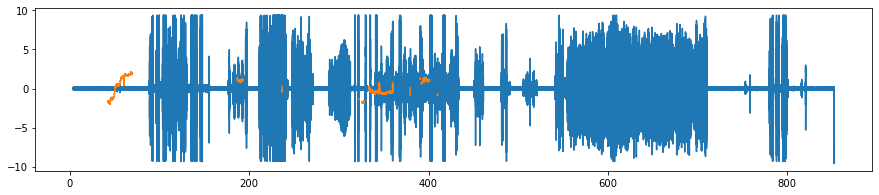

In [56]:
fig, axs = plt.subplots(figsize=(15,3))
axs.plot(timestamps,vol_z)
axs.plot(block.final_sync_df['Arena_TTL'].values/20000,re_el_z)

In [55]:
re_el_z = (block.re_df.ellipse_size - block.re_df.ellipse_size.mean()) / block.re_df.ellipse_size.std()
vol_z = (volume_trace - np.mean(volume_trace)) / np.std(volume_trace)

In [59]:
#def block_eye_plot(self, export=False, ms_x_axis=True, plot_saccade_locs=False,
#                  saccade_frames_l=None, saccade_frames_r=None):
# setup
ms_x_axis = True
export = True
plot_saccade_locs = False
saccade_frames_l = None
saccade_frames_r = None

# normalize values:
le_el_z = (block.le_df.ellipse_size - block.le_df.ellipse_size.mean()) / block.le_df.ellipse_size.std()
le_x_z = (block.le_df.center_x - np.mean(block.le_df.center_x)) / block.le_df.center_x.std()
le_y_z = (block.le_df.center_y - np.mean(block.le_df.center_y)) / block.le_df.center_y.std()
re_el_z = (block.re_df.ellipse_size - block.re_df.ellipse_size.mean()) / block.re_df.ellipse_size.std()
re_x_z = (block.re_df.center_x - np.mean(block.re_df.center_x)) / block.re_df.center_x.std()
re_y_z = (block.re_df.center_y - np.mean(block.re_df.center_y)) / block.re_df.center_y.std()
vol_z = (volume_trace - np.mean(volume_trace)) / np.std(volume_trace)

if ms_x_axis is False:
    x_axis = block.final_sync_df['Arena_TTL'].values
    b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                   x_axis_label='OE Timestamps',
                   y_axis_label='Z score',
                   plot_width=1500,
                   plot_height=700)
else:
    x_axis = (block.final_sync_df['Arena_TTL'].values -
              block.final_sync_df['Arena_TTL'].values[0]) / (block.sample_rate / 1000)
    b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                   x_axis_label='[Milliseconds]',
                   y_axis_label='[Z score]',
                   plot_width=1500,
                   plot_height=700)
b_fig.add_tools(HoverTool())
b_fig.line(x_axis, le_el_z+7, legend_label='Left Eye Diameter', line_width=1.5, line_color='blue')
#b_fig.line(x_axis, le_x_z+14, legend_label='Left Eye X Position', line_width=1, line_color='cyan')
#b_fig.line(x_axis, le_y_z, legend_label='Left Eye Y position', line_width=1, line_color='green')
b_fig.line(x_axis, re_el_z+7, legend_label='Right Eye Diameter', line_width=1.5, line_color='red')
#b_fig.line(x_axis, re_x_z+14, legend_label='Right Eye X Position', line_width=1, line_color='orange')
#b_fig.line(x_axis, re_y_z, legend_label='Right Eye Y position', line_width=1, line_color='pink')
b_fig.line(timestamps * 2000, vol_z)
if plot_saccade_locs:
    b_fig.vbar(x=saccade_frames_l, width=1, bottom=-4, top=-1,
               alpha=0.8, color='purple', legend_label='Left saccades')
    b_fig.vbar(x=saccade_frames_r, width=1, bottom=-4, top=-1,
               alpha=0.8, color='brown', legend_label='Right saccades')
if export:
    b_output.output_file(filename=str(block.analysis_path / f'pupillometry_block_{block.block_num}.html'),
                         title=f'block {block.block_num} pupillometry')
show(b_fig)

In [ ]:
# To generate the blocks:
block_numbers = [i for i in range(72,76)]
bad_blocks = []
blocklist = block_generator(block_numbers,pathlib.Path(r"Z:\Nimrod\experiments"),'PV_62',bad_blocks=bad_blocks, regev=True)
for block in blocklist:
    analyzed_block_automated_pipe(block)

In [86]:
#block definition
experiments_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = "PV_62"
date = "2023_06_21"
block_n = "072"

block = BlockSync(animal_call=animal,
                  experiment_date=date,block_num=block_n,
                  path_to_animal_folder=str(experiments_path),regev=True)
#analyzed_block_automated_pipe(block)

instantiated block number 072 at Path: Z:\Nimrod\experiments\PV_62\2023_06_21\block_072
Found the sample rate for block 072 in the xml file, it is 20000 Hz


In [87]:
block.handle_eye_videos()
block.handle_arena_files()
block.parse_open_ephys_events()

handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_072\\eye_videos\\LE\\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim1.h264', 'Z:\\Nimrod\\experiments\\PV_62\\2023_06_21\\block_072\\eye_videos\\RE\\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\\230621_pv62_audiostim1.h264']
The file Z:\Nimrod\experiments\PV_62\2023_06_21\block_072\eye_videos\RE\230621_pv62_audiostim1_640x480_60hz_experiment_1_recording_0\230621_pv62_audiostim1.mp4 already exists, no conversion necessary
Validating videos...
The video named 230621_pv62_audiostim1_LE.mp4 has reported 47995 frames and has 47995 frames, it has dropped 0 frames
The video named 230621_pv62_audiostim1.mp4 has reported 48000 frames and has 48000 frames, it has dropped 0 frames
handling arena files
no arena timestamps folder found
Arena video Names:
back_20230621T143120.mp4
left_20230621T143120.mp4
right_20230621T143120.mp4
top_

In [9]:
block.create_arena_brightness_df(threshold_value=240,export=True)

working on video Z:\Nimrod\experiments\PV_62\2023_05_02\block_043\arena_videos\videos\back_20230502T134223.mp4
working on video Z:\Nimrod\experiments\PV_62\2023_05_02\block_043\arena_videos\videos\left_20230502T134223.mp4
working on video Z:\Nimrod\experiments\PV_62\2023_05_02\block_043\arena_videos\videos\right_20230502T134223.mp4
working on video Z:\Nimrod\experiments\PV_62\2023_05_02\block_043\arena_videos\videos\top_20230502T134223.mp4
done, frame_val_list contains 4 objects


KeyError: None

In [75]:
block.synchronize_block()

  2%|▏         | 567/30900 [00:00<00:05, 5632.71it/s]

creating blocksync_df


100%|██████████| 30900/30900 [00:07<00:00, 4071.65it/s]


created blocksync_df
exported blocksync_df to Z:\Nimrod\experiments\PV_62\2023_06_21\block_075\analysis/ blocksync_df.csv


In [76]:
block.create_eye_brightness_df(threshold_value=30)

working on video Z:\Nimrod\experiments\PV_62\2023_06_21\block_075\eye_videos\LE\230621_pv62_audiostim4_640x480_60hz_experiment_1_recording_0\230621_pv62_audiostim4_LE.mp4
done, frame_val_list contains 1 objects
working on video Z:\Nimrod\experiments\PV_62\2023_06_21\block_075\eye_videos\RE\230621_pv62_audiostim4_640x480_60hz_experiment_1_recording_0\230621_pv62_audiostim4.mp4
done, frame_val_list contains 1 objects
creating Z:\Nimrod\experiments\PV_62\2023_06_21\block_075\analysis/eye_brightness_df.csv


In [77]:
block.get_eyes_diff_list(threshold=2)

index error on position 19 out of 20
index error on position 17 out of 18
The suspected lag between eye cameras is 0.0 with the direction ['right', 'late']


In [78]:
block.fix_eye_synchronization()

created manual_sync_df attribute for the block


In [79]:
block.get_blink_frames_manual(threshold=2.5)

index error on position 19 out of 20
index error on position 17 out of 18


{'left': [244.0, 3853.0, 7461.0, 11070.0, 14678.0, 18287.0, 21896.0, 25504.0],
 'right': [244.0, 3853.0, 7461.0, 11070.0, 14678.0, 18287.0, 21895.0, 25504.0]}

In [80]:
block.manual_sync_df

,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
Arena_TTL,,,,,
472378.0,455,1,1,1.267043,-0.067216
472718.0,456,2,2,1.276129,-0.072965
473058.0,457,3,4,1.276261,-0.057605
473398.0,458,4,5,1.282173,-0.052767
473737.0,459,5,6,1.279144,-0.049575
...,...,...,...,...,...
10966459.0,31350,31541,31541,0.092006,1.010832
10966799.0,31351,31542,31542,0.090803,1.050345
10967139.0,31352,31543,31543,0.096496,1.065435


In [67]:
# use this to manually shift L\R eye synchronization
eye_to_move = 'R'
block.move_eye_sync_manual(cols_to_move=[f'{eye_to_move}_eye_frame',f'{eye_to_move}_values'],step=-1)

In [81]:
block.full_sync_verification(with_arena=False)

In [82]:
block.export_manual_sync_df()

In [83]:
block.import_manual_sync_df()

In [84]:
block.read_dlc_data()

100%|██████████| 31932/31932 [00:17<00:00, 1819.79it/s]



 Done


  0%|          | 36/30900 [00:00<01:35, 324.74it/s]


 Done
populating le_df


  0%|          | 75/30900 [00:00<01:22, 371.49it/s]

populating re_video_sync_df


100%|██████████| 30900/30900 [01:41<00:00, 303.06it/s]


done
exporting to analysis folder


In [85]:
block.block_eye_plot(ms_x_axis=True)

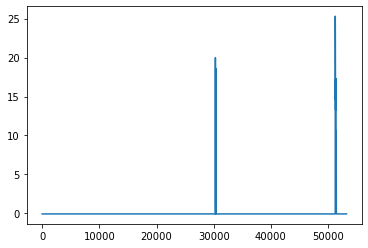

In [14]:
fig, axs = plt.subplots()
#axs.plot(np.diff(block.eye_brightness_df.R_values.values))
axs.plot(block.eye_brightness_df.R_values.values)
#axs.set_ylim(-1,1)

In [8]:
block.synchronize_arena_timestamps()

arena_sync_df already exists, loading from file...


In [33]:
r_rising = block.blink_rising_edges_detector(block.eye_brightness_df['L_values'].values,
                                            block.eye_brightness_df['L_eye_frame'], threshold=-4)
b_series = pd.Series(data=block.eye_brightness_df['R_values'].values, index=block.eye_brightness_df['R_eye_frame'])
blink_indexes = b_series[b_series < -4].index


index error on position 122 out of 123


[631.0,
 3050.0,
 3131.0,
 5955.0,
 6739.0,
 10348.0,
 10421.0,
 12752.0,
 13956.0,
 15541.0,
 17565.0,
 17728.0,
 21174.0,
 22643.0,
 24782.0,
 26873.0,
 28391.0,
 28412.0,
 29880.0,
 31999.0,
 32344.0,
 34322.0,
 35608.0,
 36829.0,
 37478.0,
 39216.0,
 39564.0,
 40480.0,
 42825.0,
 43102.0,
 45899.0,
 46434.0,
 47936.0,
 47940.0,
 49513.0,
 50042.0,
 51423.0,
 53651.0]

In [16]:
#Test oe_events_parser:
# initialize variables
open_ephys_csv_path = block.block_path / rf'oe_files' / block.exp_date_time / 'events.csv'
channel_names = block.channeldict
arena_channel_name='Arena_TTL'
export_path=None

# infer the active channels:
df = pd.read_csv(open_ephys_csv_path)
channels = np.unique(df['line'].to_numpy(copy=True))
df_onstate = df[df['state'] == 1]  # cut the df to represent only rising edges
ls = []
for chan in channels:  # extract a pandas series of the ON stats timestamps for each channel
    if chan in channel_names.keys():
        sname = channel_names[chan]
        s = pd.Series(df_onstate['sample_number'][df_onstate['line'] == chan], name=sname)
        # If this is the arena channel we need to collect the first and last frames which correspond with
        # the video itsef (as TTLs are always being transmitted and a pause is expected before the video starts
        if sname == arena_channel_name:
            diff_series = np.diff(s)
            diff_mode = stats.mode(diff_series)[0][0]
            arena_start_stop = np.where(diff_series > 10 * diff_mode)[0]
            if len(arena_start_stop) != 2:
                start_ind = input(f'there is some kind of problem because there should be 2 breaks in the arena TTLs'
                        f'and there are {len(arena_start_stop)}, those indices are: {[s.iloc[i] for i in arena_start_stop]}... '
                                  f'choose the index to use as startpoint:')
                end_ind = input('choose the index to use as endpoint:')
                arena_start_timestamp = s.iloc[arena_start_stop[int(start_ind)] + 1]
                print(f'arena first frame timestamp: {arena_start_timestamp}')
                arena_end_timestamp = s.iloc[arena_start_stop[int(end_ind)]]
                print(f'arena end frame timestamp: {arena_end_timestamp}')
            else:
                print(f'the arena TTLs are signaling start and stop positions at {arena_start_stop}')
                arena_start_timestamp = s.iloc[arena_start_stop[0] + 1]
                print(f'arena first frame timestamp: {arena_start_timestamp}')
                arena_end_timestamp = s.iloc[arena_start_stop[1]]
                print(f'arena end frame timestamp: {arena_end_timestamp}')
        else:
            print(f'{sname} was not identified as {arena_channel_name}')
        # create a counter for every rising edge - these should match video frames
        s_counter = pd.Series(data=np.arange(len(s), dtype='Int32'), index=s.index.values, name=sname+'_frame')
        ls.append(s)
        ls.append(s_counter)
# concatenate all channels into a dataframe with open-ephys compatible timestamps
open_ephys_events = pd.concat(ls, axis=1)
# use arena start_stop to clean TTLs counted before video starts and after video ends
open_ephys_events[f'{arena_channel_name}_frame'] = open_ephys_events[f'{arena_channel_name}_frame'] - (
            arena_start_stop[0] + 1)
open_ephys_events[f'{arena_channel_name}_frame'][open_ephys_events[f'{arena_channel_name}_frame'] < 0] = np.nan
open_ephys_events[f'{arena_channel_name}_frame'][
open_ephys_events[f'{arena_channel_name}'] > arena_end_timestamp] = np.nan

if export_path is not None:
    if export_path not in os.listdir(str(open_ephys_csv_path).split('events.csv')[0][:-1]):
        open_ephys_events.to_csv(export_path)


the arena TTLs are signaling start and stop positions at [ 1661 24692]
arena first frame timestamp: 1074086
arena end frame timestamp: 8896453
LED_driver was not identified as Arena_TTL
L_eye_TTL was not identified as Arena_TTL
R_eye_TTL was not identified as Arena_TTL


<ipython-input-16-2685f8107403>:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  s_counter = pd.Series(data=np.arange(len(s), dtype='Int32'), index=s.index.values, name=sname+'_frame')
<ipython-input-16-2685f8107403>:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  s_counter = pd.Series(data=np.arange(len(s), dtype='Int32'), index=s.index.values, name=sname+'_frame')
<ipython-input-16-2685f8107403>:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  s_counter = pd.Series(data=np.arange(len(s), dtype='Int32'), index=s.index.values, name=sname+'_frame')
<ipython-input-16-2685f8107403>:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  s_counter = pd.Series(data=np.arange(len(s), dtype='Int32'), index=s.index.values, name=sname+'_frame')


In [14]:
open_ephys_events[['Arena_TTL','Arena_TTL_frame']].dropna()

,Arena_TTL,Arena_TTL_frame
1187,107638575.0,0.0
1189,107638914.0,1.0
1191,107639254.0,2.0
1193,107639593.0,3.0
1195,107639932.0,4.0
...,...,...
359317,127969237.0,59875.0
359323,127969576.0,59876.0
359329,127969915.0,59877.0
359335,127970255.0,59878.0


In [7]:

for vid in block.arena_videos:
    cap = cv2.VideoCapture(str(vid))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f'The video named {os.path.split(vid)[1]} has {length} frames')
    cap.release()

The video named back_20230502T134223.mp4 has 53936 frames
The video named left_20230502T134223.mp4 has 53935 frames
The video named right_20230502T134223.mp4 has 53936 frames
The video named top_20230502T134223.mp4 has 53933 frames


In [18]:
x = 1184269.477 * 1e12
pd.to_datetime(x)

Timestamp('2007-07-12 19:44:37')

In [19]:
import time

time.time()

1686827321.674252

In [153]:
# synchronize arena timestamps with the new system:
# The problem = number of frames does not align with number of ttls transmitted by the arduino + different cameras take different number of frames
# solution:
# 1. go through the csv files to see real frame-counts vs actual frames gathered
#arena_timestamps = [i for i in glob.glob(block.arena_files[0].parent / 'frame_timestamps')]
#arena_timestamps
arena_timestamp_files = [i for i in (block.arena_files[0].parent / 'frames_timestamps').iterdir()]
# read the timestamp files
len_list = []
df_list = []
for p in arena_timestamp_files:
    if p.name != 'events.csv':
        df = pd.read_csv(p, index_col=0)
        df  = df.rename(columns={'0':'timestamp'})
        df_list.append(df)
        len_list.append(len(df))

# pick the longest as anchor
anchor_ind = len_list.index(max(len_list))
anchor_vid = df_list[anchor_ind]

In [154]:
anchor_vid_name = block.arena_vidnames[anchor_ind]
block.arena_sync_df = pd.DataFrame(data=[],
                                  columns=block.arena_vidnames,
                                  index=range(len(anchor_vid)))
block.arena_sync_df[block.arena_sync_df.columns[anchor_ind]] = range(len(anchor_vid))
vids_to_sync = list(block.arena_sync_df.drop(axis=1, labels=anchor_vid_name).columns)
anchor_vid_df = df_list.pop(anchor_ind)
df_to_sync = df_list
print('Synchronizing the different arena videos')
for row in tqdm(block.arena_sync_df.index):
    anchor = anchor_vid.timestamp[row]
    for vid in range(len(df_to_sync)):
        frame_num = block.get_closest_frame(anchor, df_to_sync[vid])
        block.arena_sync_df.loc[row, vids_to_sync[vid]] = frame_num
print(f'The anchor video used was "{block.anchor_vid_name}"')

  0%|          | 46/91552 [00:00<06:41, 228.12it/s]

Synchronizing the different arena videos


100%|██████████| 91552/91552 [07:10<00:00, 212.69it/s]

The anchor video used was "None"


In [6]:
# Independent eye tracking sync:
# Pseudo:
block.blocksync_df.Arena_frame.values[-1]

AttributeError: 'NoneType' object has no attribute 'Arena_frame'